# **MODULES**

In [1]:
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 28.9 MB/s 
     |████████████████████████████████| 96 kB 6.4 MB/s 
     |████████████████████████████████| 9.4 MB 43.7 MB/s 
     |████████████████████████████████| 88 kB 7.0 MB/s 
     |████████████████████████████████| 295 kB 69.9 MB/s 
     |████████████████████████████████| 965 kB 61.7 MB/s 
     |████████████████████████████████| 1.1 MB 56.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=f254fcc44cd6c2e3790fd7ff482434bde2f16e4fbd8540cc812f082bd4df27fb
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=bd9ff7dab4c8f5b5eb8eb97e40d7665a3c40eb6aae8d28eca1eed2bc6e94adf6
  Stored in direct

In [2]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.6.2
Uninstalling matplotlib-3.6.2:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.2-py3.8-nspkg.pth
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.2.dist-info/*
    /usr/local/lib/python3.8/dist-packages/matplotlib/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.8/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 23.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

In [3]:
import scanpy as sc

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn

from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.exponential import Exponential
from torch.optim.lr_scheduler import ConstantLR

from torch.utils.data import DataLoader, Dataset

from sklearn.decomposition import PCA

import pandas as pd

In [4]:
cuda = True
device = torch.device("cuda" if cuda else "cpu")

In [5]:
from google.colab import drive
drive.mount('/content/drive')
END_PATH = "/content/drive/MyDrive/Colab Notebooks/sad2/projekt/"

Mounted at /content/drive


# **CUSTOM DATASET**

In [6]:
class h5adDataset(Dataset):
    def __init__(self, train=True, raw=False, n_obs=None):
        self.path = "/content/drive/MyDrive/Colab Notebooks/sad2/projekt/SAD2022Z"
        if train:
            self.path += "/SAD2022Z_Project1_GEX_train.h5ad"
        else:
            self.path += "/SAD2022Z_Project1_GEX_test.h5ad"

        base = sc.read_h5ad(self.path)

        if n_obs is not None:
            base = sc.pp.subsample(base, n_obs=n_obs, copy=True)

        if raw:
            data = base.layers["counts"].X.toarray()
        else:
            data = base.X.toarray()

        self.root = torch.from_numpy(data).to(device)
        # normalize
        self.root = torch.log1p(self.root)

        cell_types = base.obs["cell_type"].to_numpy()

        self.encoded_cell_types, self.cell_type_dict = self.encode(cell_types)

    @staticmethod
    def encode(arr):
        idx = 0
        unique_dict = {}
        encoded = torch.zeros(arr.shape[0])
        for i, el in enumerate(arr):
            curr_idx = None
            if el in unique_dict:
                curr_idx = unique_dict[el]
            else:
                unique_dict[el] = idx
                curr_idx = idx
                idx += 1
            encoded[i] = curr_idx
        return encoded.to(device), unique_dict

    def __len__(self):
        return len(self.root)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.root[idx], self.encoded_cell_types[idx]

# **MODEL**

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2)
        )
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x1 = self.layers(x)
        mean = self.fc_mean(x1)
        log_var = self.fc_log_var(x1)
        return mean, log_var

    def log_prob(self, z):
        normal_dist = Normal(0, 1)
        return normal_dist.log_prob(z)

In [8]:
class Decoder(nn.Module):
    """MultivariateNormal dist decoder"""
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        self.dist = None

        self.eps = 1e-8
        
    def construct_dist(self, x_means, hyper_parameter):
        x_means = torch.where(x_means > 0, x_means, self.eps)

        cov_matrix = torch.diag(torch.zeros(x_means.shape[1])+hyper_parameter).to(device)
        # cov_matrix = torch.unsqueeze(cov_matrix, dim=0).expand(x_means.shape[0], x_means.shape[1], x_means.shape[1])

        return MultivariateNormal(x_means, cov_matrix)
        
    def forward(self, x, hyper_parameter):
        """Returns means for decoder distribution"""
        x_means = self.layers(x)
        self.dist = self.construct_dist(x_means, hyper_parameter)
        return self.dist.sample()

    def log_prob(self, x):
        return self.dist.log_prob(x)


class ExponentialDecoder(Decoder):
    """Exponential dist decoder"""
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(ExponentialDecoder, self).__init__(latent_dim, hidden_dim, output_dim)

    def construct_dist(self, x_rates):
        x_rates = torch.where(x_rates > 0, x_rates, self.eps)
        return Exponential(x_rates)
        
    def forward(self, x):
        x_rates = self.layers(x)
        
        self.dist = self.construct_dist(x_rates)
        return self.dist.sample()

    def log_prob(self, x):
        return self.dist.log_prob(x)

In [9]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

        self.latent = None
        self.cell_types = None

    def reparameterization(self, mean, log_var):
        norm = torch.normal(
            0, 1, size = mean.shape
        ).to(device)

        return mean + torch.exp(0.5*log_var) * norm
                
    def forward(self, x, hyper_parameter):
        mean, log_var = self.Encoder(x)
        sample = self.reparameterization(mean, log_var)

        self.latent = sample
        
        x_hat = self.Decoder(sample, hyper_parameter)
        decoder_log_prob = self.Decoder.log_prob(x)
        return x_hat, mean, log_var, decoder_log_prob

    def generate(self, mean, log_var, hyper_parameter):
        sample = self.reparameterization(mean, log_var)
        return self.Decoder(sample, hyper_parameter)


class ExponentialModel(Model):
    def __init__(self, Encoder, Decoder):
        super(ExponentialModel, self).__init__(Encoder, Decoder)
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        sample = self.reparameterization(mean, log_var)

        self.latent = sample
        
        x_hat = self.Decoder(sample)
        decoder_log_prob = self.Decoder.log_prob(x)
        return x_hat, mean, log_var, decoder_log_prob

    def generate(self, mean, log_var):
        sample = self.reparameterization(mean, log_var)
        return self.Decoder(sample)

# **PLOT FUNC**

In [10]:
def plot_loss(data, name, path):
    fig, ax = plt.subplots()

    loss = ax.scatter(np.arange(len(data)), [i[0] for i in data], c = "blue")
    rec = ax.scatter(np.arange(len(data)), [i[1] for i in data], c = "green")
    reg = ax.scatter(np.arange(len(data)), [i[2] for i in data], c = "red")

    plt.legend((loss, rec, reg),
            ('loss', 'rec', 'reg'),
            fontsize=8)
    
    ax.set_ylabel('Loss')
    plt.xlabel("Epochs")

    plt.savefig(path + f"{name}.png", dpi=100)
    
    plt.show()

# **LOSS FUNC**

In [11]:
def loss_function(x, x_hat, mean, log_var, decoder_log_prob, beta):
    rec_loss = -torch.sum(decoder_log_prob)
    KLD = -0.5*torch.sum(1 + log_var - torch.exp(log_var) - mean**2)
    return rec_loss + beta*KLD, rec_loss, beta*KLD

# **SAVE LATENT FUNC**

In [12]:
def save_latent(model, path="", extra=""):
    latent_space_tensor = model.latent.cpu().detach()
    cell_types = model.cell_types.cpu().detach()

    if isinstance(model, ExponentialModel):
        latent_space_filename = f"{extra}exponential_latent_space_dim_{latent_space_tensor.shape[1]}.pt"
        cell_type_filename = f"{extra}exponential_cell_types_latent_space_dim_{latent_space_tensor.shape[1]}.pt"
    else:
        latent_space_filename = f"{extra}latent_space_dim_{latent_space_tensor.shape[1]}.pt"
        cell_type_filename = f"{extra}cell_types_latent_space_dim_{latent_space_tensor.shape[1]}.pt"
    
    torch.save(latent_space_tensor, path + latent_space_filename)
    torch.save(cell_types, path + cell_type_filename)

# **TRAINING**

In [13]:
def train_model(x_dim, hidden_dim, latent_dim, epochs, test_interval, beta_hp, dataloader_tr, dataloader_te, exponential=False, sd_hp=None):
    encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)

    if exponential:
        decoder = ExponentialDecoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
        model = ExponentialModel(Encoder=encoder, Decoder=decoder).to(device)
    else:
        decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
        model = Model(Encoder=encoder, Decoder=decoder).to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = ConstantLR(optimizer, factor=0.5, total_iters=epochs)

    model.train()

    training_loss_data = []
    testing_loss_data = []

    te_iter = iter(dataloader_te)

    for epoch in range(EPOCHS):
        overall_training_loss = 0
        overall_training_rec = 0
        overall_training_reg = 0

        for i, (x, cell_types) in enumerate(dataloader_tr):
            optimizer.zero_grad()
            if exponential:
                x_hat, mean, log_var, decoder_log_prob = model(x)
            else:
                x_hat, mean, log_var, decoder_log_prob = model(x, sd_hp)

            model.cell_types = cell_types

            loss, rec, reg = loss_function(x, x_hat, mean, log_var, decoder_log_prob, beta_hp)
            overall_training_loss += loss.item()
            overall_training_rec += rec.item()
            overall_training_reg += reg.item()

            loss.backward()
            optimizer.step()

        if ((epoch+1) % test_interval == 0):
            x_te, cell_types = next(te_iter)
            if exponential:
                x_hat, mean, log_var, decoder_log_prob = model(x)
            else:
                x_hat, mean, log_var, decoder_log_prob = model(x_te, sd_hp)

            model.cell_types = cell_types
            loss_te, rec, reg = loss_function(x_te, x_hat, mean, log_var, decoder_log_prob, beta_hp)
            testing_loss_data.append((loss_te.item(), rec.item(), reg.item()))
            print("\tEpoch", epoch + 1, "Average Testing Loss: ", loss_te.item())

        info_loss = overall_training_loss / (len(dataloader_tr) * BATCH_SIZE)
        info_rec = overall_training_rec / (len(dataloader_tr) * BATCH_SIZE)
        info_reg = overall_training_reg / (len(dataloader_tr) * BATCH_SIZE)

        training_loss_data.append((info_loss, info_rec, info_reg))
        print("\tEpoch", epoch + 1, "Average Loss: ", info_loss)

        scheduler.step()
    
    model.eval()

    save_latent(model, END_PATH)
    if exponential:
        plot_loss(training_loss_data, f"exponential_training_ld{latent_dim}_plot", END_PATH)
        plot_loss(testing_loss_data, f"exponential_testing_ld{latent_dim}_plot", END_PATH)
        torch.save(model.state_dict(), END_PATH + f"exponential_model_ld_{latent_dim}")
    else:
        plot_loss(training_loss_data, f"training_ld{latent_dim}_plot", END_PATH)
        plot_loss(testing_loss_data, f"testing_ld{latent_dim}_plot", END_PATH)
        torch.save(model.state_dict(), END_PATH + f"model_ld_{latent_dim}")

    return model

In [28]:
dataset_tr = h5adDataset(train=True, n_obs=10000)
dataset_te = h5adDataset(train=False, n_obs=1000)
# dataset_tr = h5adDataset(train=True)
# dataset_te = h5adDataset(train=False)

BATCH_SIZE = 25

DATALOADER_TR = DataLoader(dataset_tr, BATCH_SIZE, shuffle=True)
DATALOADER_TE = DataLoader(dataset_te, BATCH_SIZE, shuffle=True)

In [29]:
X_DIM  = 5000
HIDDEN_DIM = 1000
LATENT_DIMS = [600, 300, 100]

EPOCHS = 35
TEST_INTERVAL = 5

SD_HYPER_PARAMETER = 0.07
BETA = 10

LR = 0.00001

	Epoch 1 Average Loss:  504.65314658203124
	Epoch 2 Average Loss:  455.299821484375
	Epoch 3 Average Loss:  455.2455083984375
	Epoch 4 Average Loss:  455.2269053710938
	Epoch 5 Average Testing Loss:  11117.42578125
	Epoch 5 Average Loss:  455.22895458984374
	Epoch 6 Average Loss:  455.15980947265626
	Epoch 7 Average Loss:  455.12191826171875
	Epoch 8 Average Loss:  455.1154959960937
	Epoch 9 Average Loss:  455.1320903320312
	Epoch 10 Average Testing Loss:  11565.9619140625
	Epoch 10 Average Loss:  455.109709765625
	Epoch 11 Average Loss:  455.08696904296875
	Epoch 12 Average Loss:  455.0888115234375
	Epoch 13 Average Loss:  455.066023046875
	Epoch 14 Average Loss:  455.047252734375
	Epoch 15 Average Testing Loss:  9026.4892578125
	Epoch 15 Average Loss:  454.9956765625
	Epoch 16 Average Loss:  454.95994580078127
	Epoch 17 Average Loss:  454.94044560546877
	Epoch 18 Average Loss:  454.94882216796873
	Epoch 19 Average Loss:  484.87294755859375
	Epoch 20 Average Testing Loss:  12163.93847

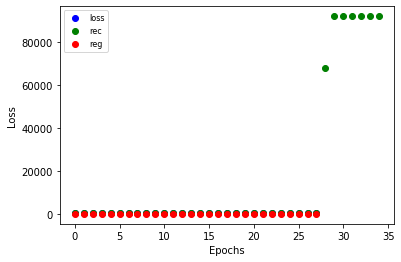

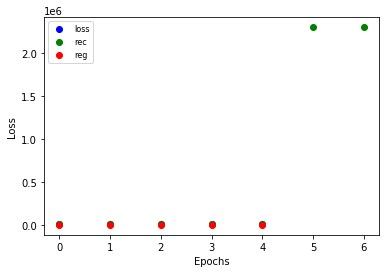

	Epoch 1 Average Loss:  504.465433984375
	Epoch 2 Average Loss:  455.2925390625
	Epoch 3 Average Loss:  455.26375712890626
	Epoch 4 Average Loss:  455.21700361328124
	Epoch 5 Average Testing Loss:  13206.3427734375
	Epoch 5 Average Loss:  455.1979208984375
	Epoch 6 Average Loss:  455.17119169921875
	Epoch 7 Average Loss:  455.13070302734377
	Epoch 8 Average Loss:  455.12977724609374
	Epoch 9 Average Loss:  455.1444748046875
	Epoch 10 Average Testing Loss:  12156.50390625
	Epoch 10 Average Loss:  455.1102626953125
	Epoch 11 Average Loss:  455.05764736328126
	Epoch 12 Average Loss:  455.0746994140625
	Epoch 13 Average Loss:  455.03675361328123
	Epoch 14 Average Loss:  454.99703701171876
	Epoch 15 Average Testing Loss:  10755.1455078125
	Epoch 15 Average Loss:  454.97117724609376
	Epoch 16 Average Loss:  454.9260451171875
	Epoch 17 Average Loss:  454.9158173828125
	Epoch 18 Average Loss:  454.91777587890624
	Epoch 19 Average Loss:  454.91967197265626
	Epoch 20 Average Testing Loss:  10121

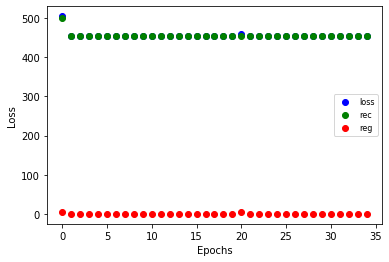

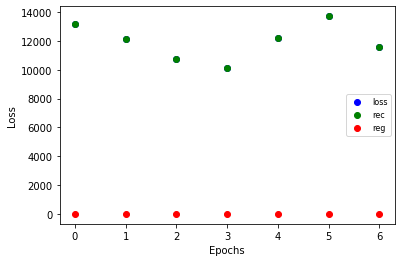

	Epoch 1 Average Loss:  503.9667806640625
	Epoch 2 Average Loss:  455.24922060546874
	Epoch 3 Average Loss:  455.1859931640625
	Epoch 4 Average Loss:  455.20467919921873
	Epoch 5 Average Testing Loss:  13019.2275390625
	Epoch 5 Average Loss:  455.1783875
	Epoch 6 Average Loss:  455.13779458007815
	Epoch 7 Average Loss:  455.13973740234377
	Epoch 8 Average Loss:  455.12066650390625
	Epoch 9 Average Loss:  455.1227451171875
	Epoch 10 Average Testing Loss:  10601.310546875
	Epoch 10 Average Loss:  455.07681943359376
	Epoch 11 Average Loss:  455.0824123046875
	Epoch 12 Average Loss:  455.02445615234376
	Epoch 13 Average Loss:  455.01321708984375
	Epoch 14 Average Loss:  455.00689716796876
	Epoch 15 Average Testing Loss:  11546.69140625
	Epoch 15 Average Loss:  454.9802145507812
	Epoch 16 Average Loss:  454.92140966796876
	Epoch 17 Average Loss:  454.924223828125
	Epoch 18 Average Loss:  454.9110759765625
	Epoch 19 Average Loss:  454.89572119140627
	Epoch 20 Average Testing Loss:  11426.306

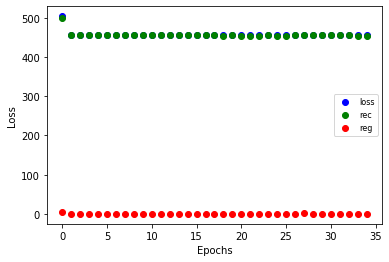

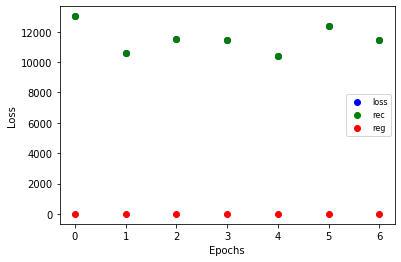

In [30]:
models = [
    train_model(X_DIM, HIDDEN_DIM, latent_dim, EPOCHS, TEST_INTERVAL, BETA, DATALOADER_TR, DATALOADER_TE, sd_hp=SD_HYPER_PARAMETER, exponential=True) 
    for latent_dim in LATENT_DIMS
]

# **LOAD MODELS**

In [17]:
def load_models(x_dim, hidden_dim, latent_dims, exponential=False):
  models = []
  for latent_dim in latent_dims:
    encoder = Encoder(x_dim, hidden_dim, latent_dim)
    if exponential:
      decoder = ExponentialDecoder(latent_dim, hidden_dim, x_dim)
      model = ExponentialModel(encoder, decoder)
    else:
      decoder = Decoder(latent_dim, hidden_dim, x_dim)
      model = Model(encoder, decoder)
    models.append(model.to(device))

    model.load_state_dict(torch.load(END_PATH + f"model_ld_{latent_dim}"))
    model.eval()

  return models

LOAD = False
if LOAD:
  models = load_models(X_DIM, HIDDEN_DIM, LATENT_DIMS, exponential=False)

# **PCA**

In [18]:
def pca_analysis(filename):
    latent_space = torch.load(filename)

    latent_space_size = latent_space.shape[1]

    print("latent space size:", latent_space_size)

    pca = PCA(0.95)
    pca.fit(latent_space)

    out = len(pca.explained_variance_ratio_)

    print(f"number of principal components that explain more than 95% of the variance: {out}")
    return (latent_space_size, out)

In [21]:
latent_analysis_data = [
    pca_analysis(END_PATH + "exponential_latent_space_dim_100.pt"), 
    pca_analysis(END_PATH + "exponential_latent_space_dim_300.pt"), 
    pca_analysis(END_PATH + "exponential_latent_space_dim_600.pt")
]

# latent_analysis_data = [
#     pca_analysis(END_PATH + "latent_space_dim_100.pt"), 
#     pca_analysis(END_PATH + "latent_space_dim_300.pt"), 
#     pca_analysis(END_PATH + "latent_space_dim_600.pt")
# ]

train_pca_df = pd.DataFrame(
    data={
        "latent_space_size": [i[0] for i in latent_analysis_data],
        "over_95_number_of_components": [i[1] for i in latent_analysis_data]
    }
)

train_pca_df.to_csv(END_PATH + "train_pca_df.csv")

latent space size: 100
number of principal components that explain more than 95% of the variance: 21
latent space size: 300
number of principal components that explain more than 95% of the variance: 22
latent space size: 600
number of principal components that explain more than 95% of the variance: 22


# **LATENT SPACE ON TEST**

In [22]:
def latent_space_te(models, dataloader_te, exponential=False, sd_hp=None):
    test_x, test_cell_types = next(iter(dataloader_te))

    for model in models:
        if exponential:
            x_hat, mean, log_var, decoder_log_prob = model.forward(test_x)
        else:
            x_hat, mean, log_var, decoder_log_prob = model.forward(test_x, sd_hp)

        model.cell_types = test_cell_types
        save_latent(model, END_PATH, "te_")

latent_space_te(models, DATALOADER_TE, True, SD_HYPER_PARAMETER)

# **PLOT LATENT SPACE FUNC**

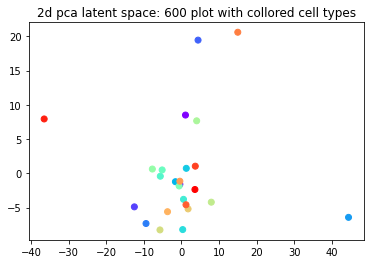

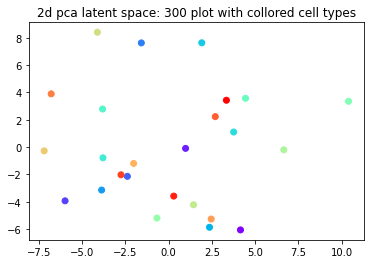

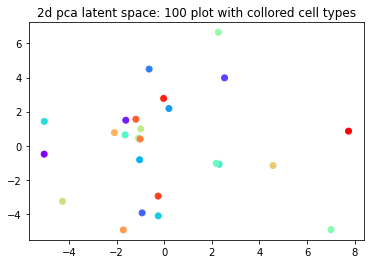

In [23]:
def plot_latent_space(latent_space_filename, cell_types_filename, path):
    latent_space = torch.load(latent_space_filename)
    cell_types = torch.load(cell_types_filename)

    pca = PCA(n_components=2)
    pca.fit(latent_space)
    x = pca.transform(latent_space)

    fig, ax = plt.subplots()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(cell_types)))
    ax.scatter(x[:, 0], x[:, 1], c=colors)
    plt.title(f"2d pca latent space: {latent_space.shape[1]} plot with collored cell types")

    fig.savefig(path + f"latent_size_space_{latent_space.shape[0]}_{latent_space.shape[1]}.png", dpi=300)

def plot_latent_spaces(latent_dims, path="content/", exponential=False, test=False):
    for dim in latent_dims:
        if exponential:
            plot_latent_space(path + f"exponential_latent_space_dim_{dim}.pt", path + f"exponential_cell_types_latent_space_dim_{dim}.pt", END_PATH)
        elif test:
            plot_latent_space(path + f"te_latent_space_dim_{dim}.pt", path + f"te_cell_types_latent_space_dim_{dim}.pt", END_PATH)
        else:
            plot_latent_space(path + f"latent_space_dim_{dim}.pt", path + f"cell_types_latent_space_dim_{dim}.pt", END_PATH)

plot_latent_spaces(LATENT_DIMS, END_PATH, exponential=True, test=True)